# LDA

In [1]:
import pandas as pd
from ast import literal_eval
import gensim
import time
from wordcloud import WordCloud

# Load the data

In [48]:
df = pd.read_csv('../data/lemmas.csv')

In [49]:
df

,book_poem_id,lemmas
0,1_0001-0000-0000-0001-0000,"[('tvůj', 'P'), ('loď', 'N'), ('jít', 'V'), ('..."
1,1_0001-0001-0000-0001-0000,"[('už', 'D'), ('míza', 'N'), ('naplňovat', 'V'..."
2,1_0001-0001-0000-0002-0000,"[('už', 'D'), ('jaro', 'N'), ('výskat', 'V'), ..."
3,1_0001-0001-0000-0003-0000,"[('teď', 'D'), ('slunce', 'N'), ('projít', 'V'..."
4,1_0001-0001-0000-0004-0000,"[('skála', 'N'), ('nebetyčný', 'A'), ('shluk',..."
...,...,...
66423,1689_0001-0000-0000-0026-0000,"[('u', 'R'), ('altán', 'N'), ('bílý', 'A'), ('..."
66424,1689_0001-0000-0000-0027-0000,"[('nad', 'R'), ('tůně', 'N'), ('honit', 'V'), ..."
66425,1689_0001-0000-0000-0028-0000,"[('podle', 'R'), ('cesta', 'N'), ('hloh', 'N')..."
66426,1689_0001-0000-0000-0029-0000,"[('na', 'R'), ('lesní', 'A'), ('stráň', 'N'), ..."


# Select a subsample of the data

In [50]:
df_sub = df.sample(frac=1.0, random_state=42).reset_index()
# df_sub = df

In [51]:
df_sub.shape

(66428, 3)

# Filter the data
1. Filter out all POS but Nouns (N), Adjectives (A) and Verbs (V)
2. Filter out frequent (stop)words that does not carry any extra semantic information 

In [52]:
stopwords = ['mít', 'jít', 'být', 'dát', 'moci']

In [53]:
%%time

lemmas_filtered_column = []

# extract lemmas with N, A or V POS tag
for index, poem in df_sub.iterrows():
    if index % 1000 == 0:
        print(index, end=' ')
    
    lemmas_filtered_poem = []
    lemmas_poem = literal_eval(poem['lemmas'])
    for lemma_pos in lemmas_poem:
        lemma, pos = lemma_pos
        if pos in ['N', 'A', 'V'] and lemma not in stopwords:
            lemmas_filtered_poem.append(lemma)
    lemmas_filtered_column.append(lemmas_filtered_poem)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 CPU times: user 2min 33s, sys: 1.6 s, total: 2min 35s
Wall time: 2min 35s


In [54]:
df_sub['lemmas_filtered'] = lemmas_filtered_column

# Compute bigrams

In [55]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = gensim.models.Phrases(df_sub['lemmas_filtered'], min_count=20)
for idx in range(len(df_sub['lemmas_filtered'])):
    for token in bigram[df_sub['lemmas_filtered'][idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            df_sub['lemmas_filtered'][idx].append(token)

# Create a dictionary
1. BoW

In [56]:
dictionary = gensim.corpora.Dictionary(df_sub['lemmas_filtered'])

In [57]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20)

In [58]:
# Bag-of-words representation of the documents.
bow_corpus = [dictionary.doc2bow(doc) for doc in df_sub['lemmas_filtered']]

In [59]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))

Number of unique tokens: 17978
Number of documents: 66428


# Estimate the optimal number of topics

In [58]:
%%time

coherences = []

for num_topics in range(5, 121, 5):
    start = time.time()
    
    # train a model
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=1, workers=3, random_state=42)
    # compute a coherence of the model
    cm = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, texts=df_sub['lemmas_filtered'], coherence='c_v')
    coherence = cm.get_coherence()  # get coherence value
    
    coherences.append((num_topics, coherence))
    
    print('Num. topics: {}. Coherence: {} (training took {} min).'.format(num_topics, coherence, round((time.time() - start)/60, 2)))
    print(lda_model.print_topics())

Num. topics: 30. Coherence: 0.2691815979852563 (training took 0.04 min).
[(9, '0.015*"srdce" + 0.014*"svět" + 0.013*"otec" + 0.013*"bratr" + 0.013*"stát" + 0.012*"oko" + 0.011*"chtít" + 0.011*"slunce" + 0.010*"den" + 0.010*"ruka"'), (18, '0.019*"srdce" + 0.019*"láska" + 0.017*"den" + 0.015*"oko" + 0.015*"duch" + 0.014*"stát" + 0.013*"svět" + 0.012*"chtít" + 0.011*"rád" + 0.010*"žena"'), (14, '0.022*"den" + 0.019*"bílý" + 0.018*"cesta" + 0.014*"bůh" + 0.013*"oko" + 0.012*"srdce" + 0.012*"tvář" + 0.012*"práce" + 0.011*"nechat" + 0.011*"město"'), (21, '0.016*"srdce" + 0.016*"bůh" + 0.014*"bílý" + 0.012*"duch" + 0.011*"sen" + 0.011*"duše" + 0.010*"cítit" + 0.010*"tvář" + 0.010*"hvězda" + 0.010*"les"'), (3, '0.019*"stát" + 0.014*"hora" + 0.014*"srdce" + 0.013*"krev" + 0.013*"skála" + 0.012*"oko" + 0.011*"vidět" + 0.011*"ruka" + 0.011*"země" + 0.010*"květ"'), (23, '0.017*"srdce" + 0.013*"velký" + 0.012*"bůh" + 0.012*"život" + 0.011*"píseň" + 0.011*"svět" + 0.011*"země" + 0.011*"znát" + 0.010

In [59]:
topics = lda_model.print_topics(num_topics=100)

In [60]:
import re

In [61]:
topic_words = []

for t in topics:
    words = re.findall(r'"([^"]*)"', t[1])
    topic_words.append(words)

# Pick the best model

In [16]:
results_unigrams = pd.read_csv('../results/lda/results_lda.csv')
results_unigrams

,num_topics,coherence,diversity,training_time
0,5,0.397002,0.760000,7.13
1,10,0.436842,0.680000,7.31
2,15,0.446872,0.620000,7.70
3,20,0.435000,0.535000,7.77
4,25,0.447836,0.544000,8.07
5,30,0.441068,0.520000,8.25
6,35,0.447532,0.520000,8.42
7,40,0.451322,0.527500,8.28
8,45,0.445372,0.473333,8.20
9,50,0.442782,0.476000,8.50


In [17]:
results_bigrams = pd.read_csv('../results/lda/results_lda_bi.csv')
results_bigrams

,num_topics,coherence,diversity,training_time
0,5,0.411344,0.740000,6.53
1,10,0.426404,0.620000,7.02
2,15,0.433996,0.573333,7.58
3,20,0.435138,0.535000,6.64
4,25,0.446671,0.556000,6.05
5,30,0.451179,0.550000,7.11
6,35,0.444562,0.517143,8.49
7,40,0.443305,0.505000,8.23
8,45,0.449207,0.511111,10.34
9,50,0.437028,0.498000,7.61


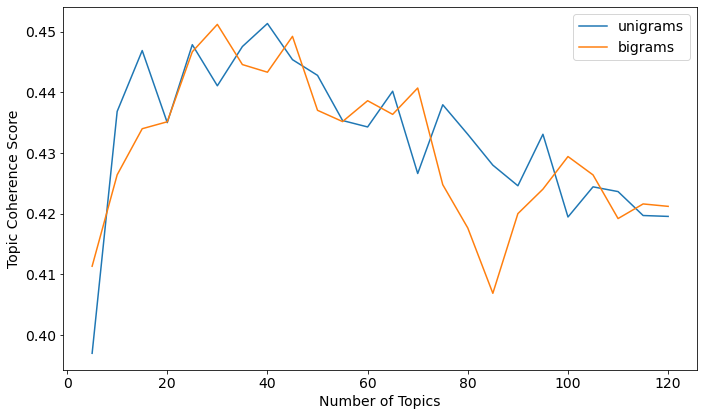

In [18]:
import matplotlib.pyplot as plt

# Set font size
plt.rcParams.update({'font.size': 14})

# separate the x and y values into two separate lists
x_values = results_unigrams.num_topics.values
y1_values = results_unigrams.coherence.values
y2_values = results_bigrams.coherence.values

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Topic Coherence Score')
ax1.plot(x_values, y1_values, label ='unigrams')
ax1.plot(x_values, y2_values, label ='bigrams')
ax1.tick_params(axis='y')

fig.tight_layout()
plt.legend()
plt.savefig('lda_coherence.png', dpi=400, bbox_inches='tight', pad_inches=0)
plt.show()

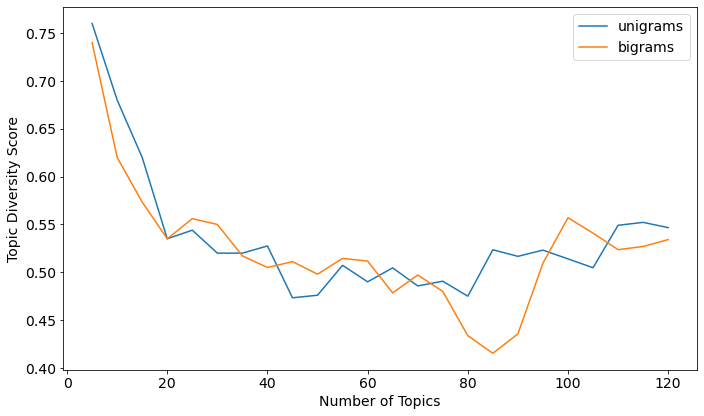

In [19]:
import matplotlib.pyplot as plt

# Set font size
plt.rcParams.update({'font.size': 14})

# separate the x and y values into two separate lists
x_values = results_unigrams.num_topics.values
y1_values = results_unigrams.diversity.values
y2_values = results_bigrams.diversity.values

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Topic Diversity Score')
ax1.plot(x_values, y1_values, label='unigrams')
ax1.plot(x_values, y2_values, label='bigrams')
ax1.tick_params(axis='y')

fig.tight_layout()
plt.legend()
plt.savefig('lda_diversity.png', dpi=400, bbox_inches='tight', pad_inches=0)
plt.show()

# Load the best model

In [2]:
lda_uni = gensim.models.LdaModel.load('../results/lda/lda_40.model')

In [60]:
lda_bi = gensim.models.LdaModel.load('../results/lda/lda_bi_30.model')

In [22]:
def word_cloud(top_n_words):
    word_dict = {word: prob for word, prob in top_n_words}

    wc = WordCloud(background_color='white', width=800, height=400)
    wc.generate_from_frequencies(word_dict)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

0


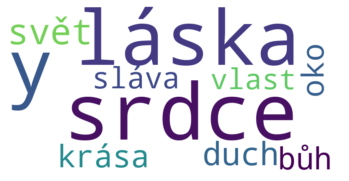

1


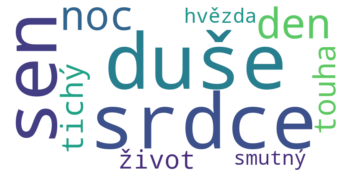

2


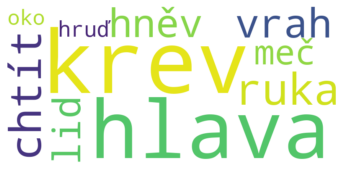

3


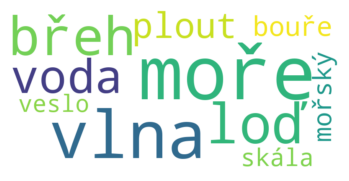

4


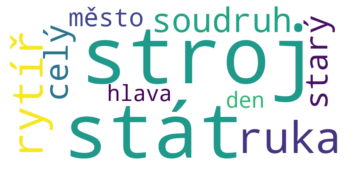

5


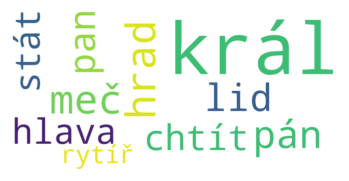

6


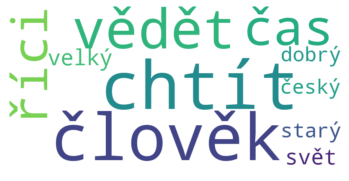

7


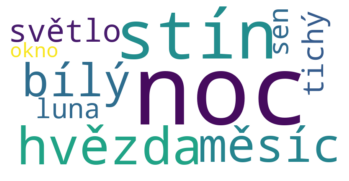

8


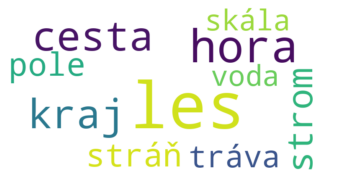

9


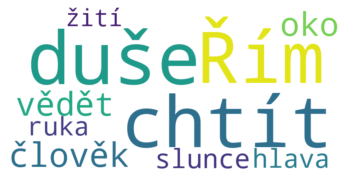

10


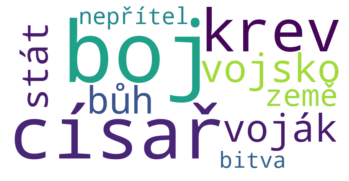

11


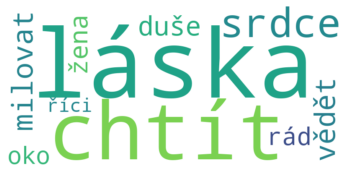

12


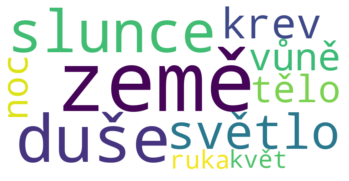

13


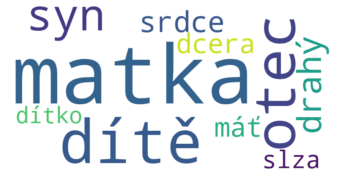

14


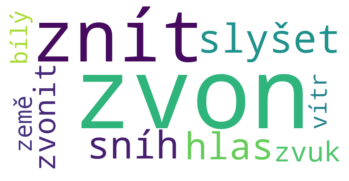

15


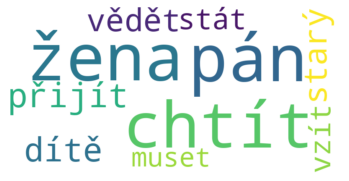

16


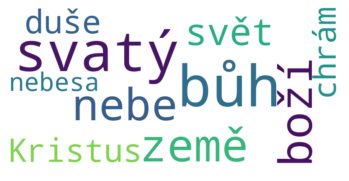

17


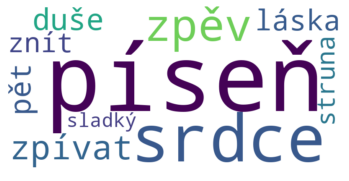

18


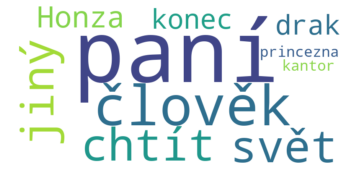

19


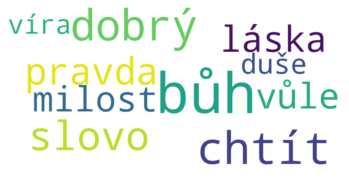

20


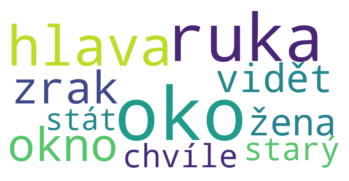

21


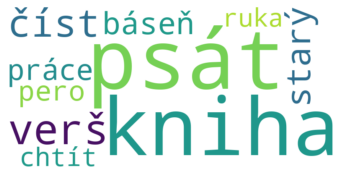

22


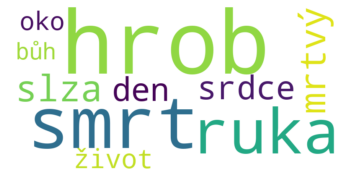

23


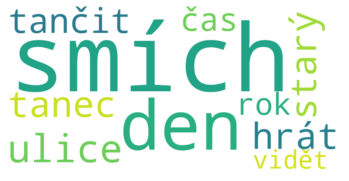

24


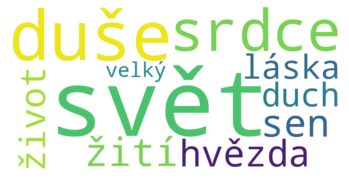

25


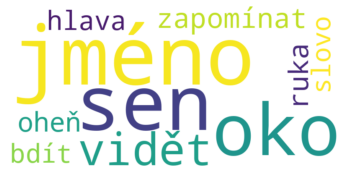

26


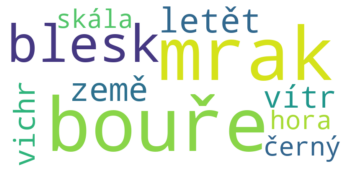

27


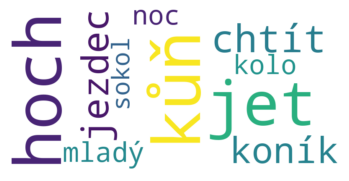

28


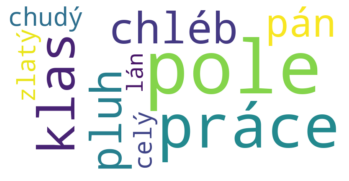

29


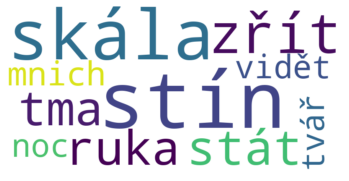

30


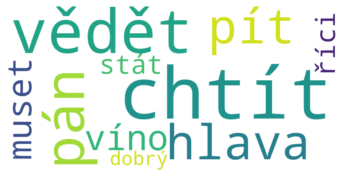

31


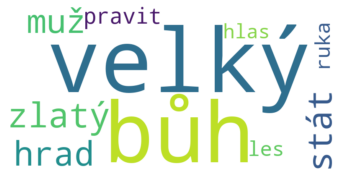

32


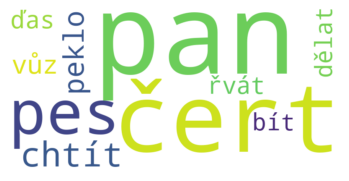

33


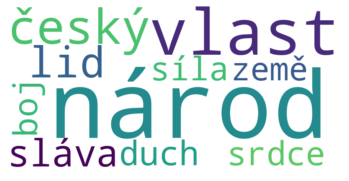

34


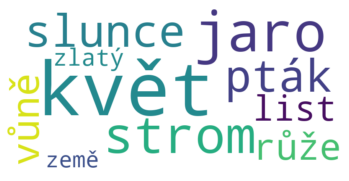

35


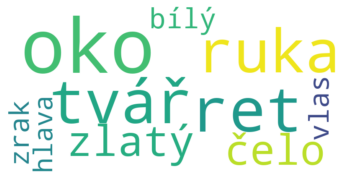

36


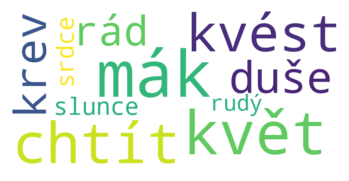

37


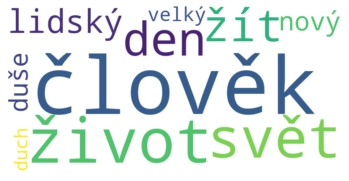

38


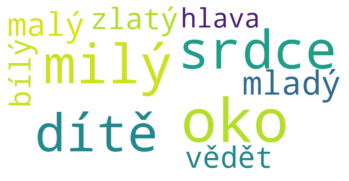

39


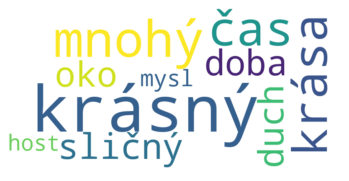

In [23]:
for i in range(40):
    print(i)
    word_cloud(lda_uni.show_topic(i, 10))

0


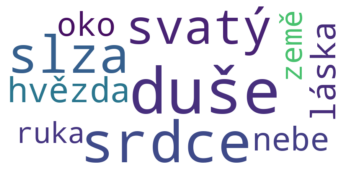

1


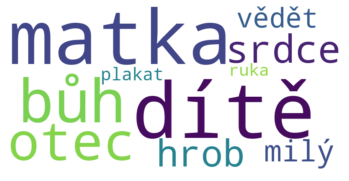

2


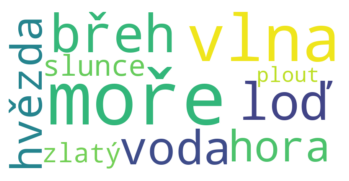

3


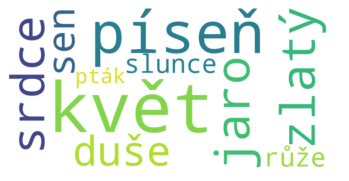

4


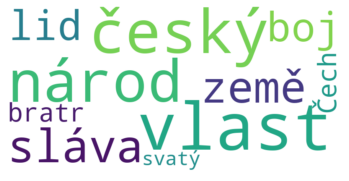

5


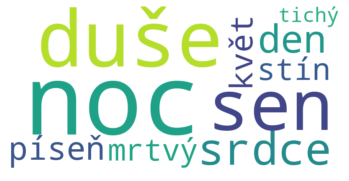

6


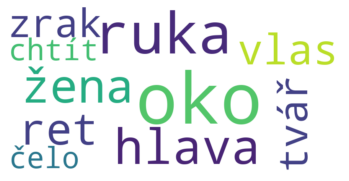

7


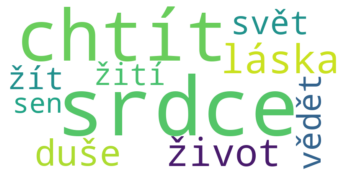

8


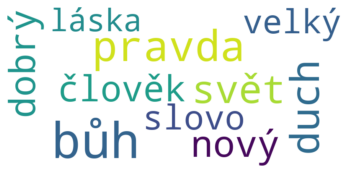

9


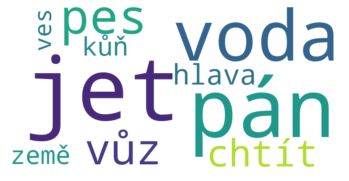

10


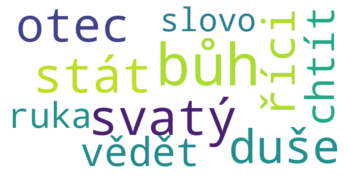

11


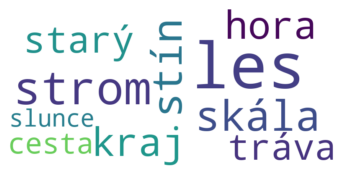

12


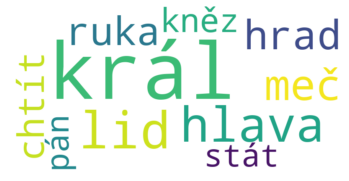

13


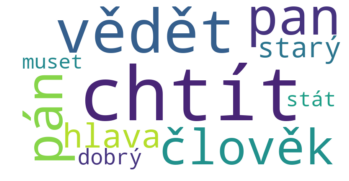

14


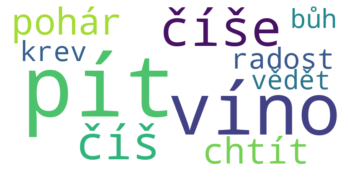

15


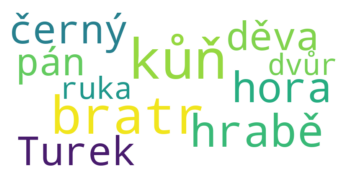

16


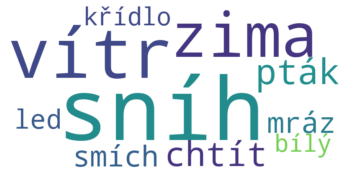

17


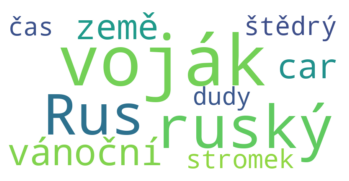

18


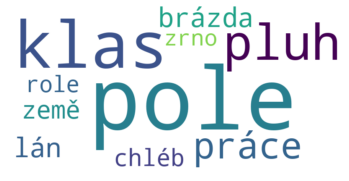

19


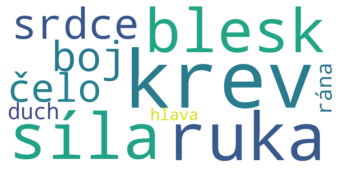

20


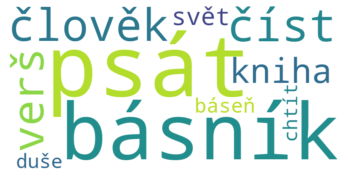

21


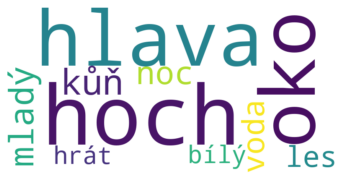

22


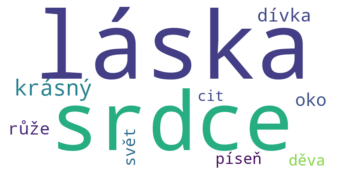

23


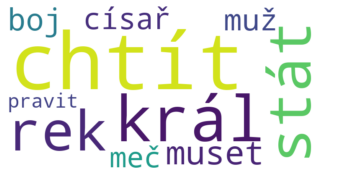

24


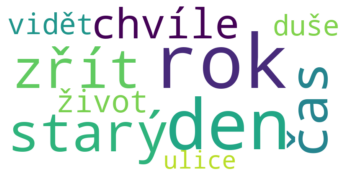

25


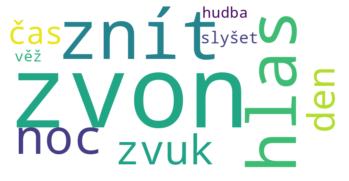

26


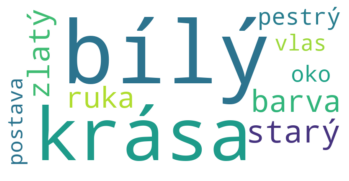

27


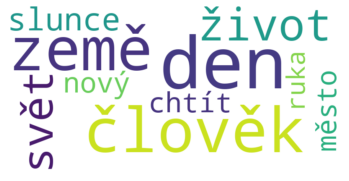

28


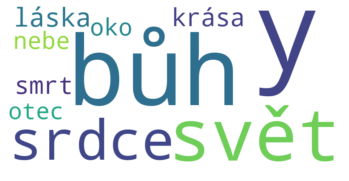

29


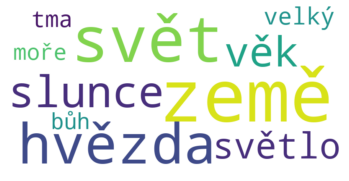

In [24]:
for i in range(30):
    print(i)
    word_cloud(lda_bi.show_topic(i, 10))

In [25]:
def word_cloud_save(top_n_words, name):
    word_dict = {word: prob for word, prob in top_n_words}

    wc = WordCloud(background_color='white', width=800, height=400)
    wc.generate_from_frequencies(word_dict)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=400)
    plt.show()

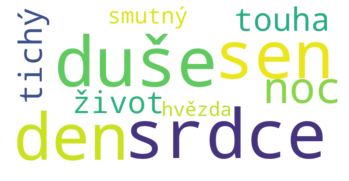

In [31]:
word_cloud_save(lda_uni.show_topic(1, 10), 'lda_uni_1.png')

In [61]:
bow_28120 = dictionary.doc2bow(df_sub.loc[28120]['lemmas_filtered'])

In [37]:
lda_uni.get_document_topics(bow=bow_28120)

[(3, 0.4331683),
 (7, 0.18935426),
 (25, 0.102087766),
 (28, 0.025650917),
 (29, 0.11454446),
 (32, 0.049119104),
 (39, 0.0677143)]

In [62]:
lda_bi.get_document_topics(bow=bow_28120)

[(2, 0.47913894),
 (6, 0.101550475),
 (15, 0.06914463),
 (18, 0.025163956),
 (21, 0.17299801),
 (29, 0.1341973)]

In [40]:
uni_words = lda_uni.get_topic_terms(topicid=3, topn=10)
uni_words

[(1670, 0.06850133),
 (1268, 0.053297967),
 (274, 0.035945605),
 (1254, 0.0330161),
 (1593, 0.025080385),
 (2253, 0.018078106),
 (264, 0.009610559),
 (1719, 0.008510468),
 (386, 0.007834646),
 (2308, 0.0072410833)]

In [63]:
bi_words = lda_bi.get_topic_terms(topicid=2, topn=10)
bi_words

[(1709, 0.028207114),
 (1292, 0.020753164),
 (1277, 0.012988562),
 (277, 0.012400729),
 (1627, 0.010348431),
 (227, 0.0086622285),
 (1101, 0.008515888),
 (191, 0.00815987),
 (678, 0.008089954),
 (2311, 0.0073591)]

In [47]:
for i in uni_words:
    w, _ = i
    print(dictionary[w])

moře
vlna
loď
břeh
voda
plout
bouře
mořský
skála
veslo


In [64]:
for i in bi_words:
    w, _ = i
    print(dictionary[w])

moře
vlna
břeh
loď
voda
hvězda
hora
slunce
zlatý
plout
